### Assignment:

**Achieve more than 80% accuracy for CIFAR-10 classification with ConvNet .**

           

In [8]:
what_we_covering =  [
            "Describe data preparation",
            "Describe model architecture",
            "How to control overfitting?",
            "Show class(es) with the most false positive"
]

### Computer Vision and Deep Learning
คอมพิวเตอร์วิชั่นเป็นสาขาที่ใหญ่มากของปัญญาประดิษฐ์ทั้งในด้านความกว้างและความลึก
เป็นสาขาของปัญญาประดิษฐ์ที่แก้ปัญหาโดยใช้โครงข่ายประสาทเทียมระดับลึก ที่เรียกว่าการเรียนรู้เชิงลึกหรือ deep learning
ในส่วนนี้ เราจะสรุปงานพื้นฐาน 3 อย่างสั้นๆ สำหรับการใช้งานอย่างหลากหลาย

**These 3 tasks are image classification, object detection, and image segmentation.**
<br>
![](image/cv.png)

# The CIFAR-10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:
![](image/cifar-10.png)
Link here - https://www.cs.toronto.edu/~kriz/cifar.html

# 1. DATA PREPARATIOIN

In [125]:
# IMPORT LIBRARY
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import plotly.figure_factory as ff
import plotly.graph_objects as go

from collections import Counter
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# DEFINE
NUM_CLASSES = 10
VAL_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 32

In [3]:
# LOAD DATA
(train_data, y), (test_data, y_test) = cifar10.load_data()

# CHECK SHAPE OF DATA
print(train_data.shape, y.shape, test_data.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


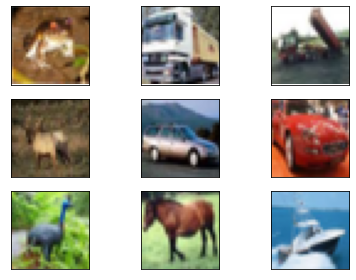

In [4]:
# SHOW IMAGE
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_data[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

ปกติค่าสีจะอยู่ในช่วง 0-255 ดังนั้นเราจะทำการแปลงค่าให้อยู่ในช่วง 0-1 เพื่อนำไป train model

In [5]:
# SCALING DATA
train_data = train_data/255.
test_data = test_data/255.

In [6]:
# CHECK LABEL
print(y.shape, y_test.shape)
y[:10]

(50000, 1) (10000, 1)


array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

**Classes**: 

0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

ทำการแปลง label ให้เป็น Categorical โดยแต่ละ class จะแทนที่ด้วย 1 ถ้าไม่ใช่จะเป็น 0

In [7]:
# ONE_HOT ENCODING TO CATEGORICAL
y = to_categorical(y)
y_test = to_categorical(y_test)

print(y.shape, y_test.shape)
y[:10]

(50000, 10) (10000, 10)


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [8]:
# SPLIT THE DATA INTO TRAIN AND VALIDATE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, y,
                                                  test_size=VAL_SIZE,
                                                  random_state=RANDOM_STATE)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (40000, 10) (10000, 10)


# 2. BUILD THE MODEL (BASELINE MODEL)

"What's this Convolutional Neural Network"
- Describe.

**CNN** (Covolutional Neural Network) เป็นโครงสร้างภายใน Deep Learning Model ที่ใช้แนวคิดของ Convolution ในการทำงานกับข้อมูล 2 มิติ เช่น `Image data ซึ่งมีลักษณะเป็น Pixel` เป็นต้น

ด้วยลักษณะโครงสร้างของ CNN ที่ออกแบบมาเพื่อทำงานกับ Image Data ในตอนเริ่มต้นเราจึงสามารถแสดงข้อมูลที่เป็นองค์ประกอบของการตัดสินใจ หรือ การทำนายของ Model ด้วยภาพได้ดีกว่า Neural Network ชนิดอื่นๆ

`CNN ประกอบด้วย Kernal` และ `ผลลัพท์จากการกระทำทางคณิตศาสตร์ของ Kernel กับ Input Image` ที่เรียกว่า `Activation Map` หรือ `Feature Map `โดยทั้ง Kernel และ Feature Map นั้นแสดงผลได้ด้วยภาพ

![](image/standardcnn.png)

`2D Convolution` เป็นการนำ Matrix ขนาดเล็กของ Weight หรือที่เรียกว่า Kernel มา Slide ไปบน 2D Input Image `(สีฟ้าเข้มในภาพด้านบน)` ในขณะที่มีการทาบ Kernel บน Input Image มันจะคูณค่าแต่ละ Pixel ของ Input Image กับ Kernel แล้วนำผลลัพท์ทั้งหมดมาบวกกันเป็น 1 จุด Pixel ของ Feature Map `(สีเขียวขวามือสุด)`

2D Convolution จะมีการสร้าง Feature Map ขึ้นมาด้วยการนำ Kernel Slide ไปบน Input image จะใช้ paramete น้อยกว่า Fully Connected Layer

`ตัวอย่างการนำภาพ` ขนาด 5x5 pixels เข้า Model 2D Convolution Layer จะใช้จำนวน Parameter เท่ากับขนาดของ Kernel คือ 3 x 3 = 9 Parametes ขณะที่ถ้าเป็น Fully Conected Layer จะใช้จำนวน Parameter เท่ากัย ขนาดของ Input Image x 9 จะได้ 5 x 5 x 9 = 225 parameters

`Input Image ด้วย Padding` - ขณะที่มีการ Slide Kernel จะเห็นว่า Pixel ตรงขอบภาพสีฟ้าจะไม่มีทางอยู่ตรงกลางของ Kernel ตอนที่มันทาบลงไป เพราะเราไม่สามารถขนาย Kernel ให้เลยออกไปข้างนอกขอบของภาพได้
ดังนั้นเพื่อที่จะทำให้ Feature Map มีขนาดเท่ากับInput Image และ Pixel ที่ขอบภาพอยู่ตรงกลาง Kernel ตอนที่มันทาบลงไป เราจะต้องมีการทำ Padding โดยการเสริมกรอบด้วยการเติม 0 (zero Padding รอบๆภาพเดิม)
![](image/samepadding.gif)

`Input Image ด้วยการทำ Pooling` - การทำ Max Pooling หรือ Average Pooling เป็นวิธีหนึ่งในการลดขนาดของภาพ จะเป็นกระบวนการทำงานนอก CNN Layer จะเป็นการเลือกตัวแทนของภาพด้วยการหาค่ามากที่สุดหรือค่าเฉลี่ยจาก Pixel ใน window ตามขนาดที่กำหนด เช่น ขนาด 2x2 จะทำให้มีการลดขนาดของภาพได้ครึ่งหนึ่งตามตัวอย่าง
![](image/maxpool.gif)

`Flatten` นั้นมีไว้เพื่อแปลงข้อมูลจากภาพหลาย channel ให้เป็นเวคเตอร์ ที่สามารถส่งต่อให้ชั้นต่อไปได้ คือการแปลงข้อมูลเป็นอาร์เรย์ 1 มิติเพื่อป้อนเลเยอร์ถัดไป สมมติว่าเราได้ 5,5,5 Pooling feature map จะถูกแปลงเป็นเวกเตอร์เดียว 1x125
![](image/flatten.png)

`Dense` คือ เชื่อมแต่ละ node ทุกอัน ของชั้น layer หนึ่งไปอีก layer หนึ่ง หรือ (fully connected)

- What should the model architecture we use.

In [9]:
# BUILD THE MODEL
model = tf.keras.Sequential([
    # 1. CNN LAYER INPUT
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    
])

Describe each layers of model:

`1st Layer Input`
โดยค่าพารามิเตอร์แรกคือ filters มีค่าเป็น 32 คือบอกว่า คือจำนวนฟิลเตอร์ทั้งหมดของเลเยอร์นี้มี 32 ชั้น พารามิเตอร์ตัวที่สองคือ kernel_size มีค่าเป็น 3x3 และ input_shape=(32, 32 ,3) คือรูปขนาด 32x32 และมี 3 channels ในนี้ก็คือ RGB, activation function เป็น relu และ padding เซ็ทไว้เป็น same  เพื่อให้ข้อมูลที่ส่งออกมีขนาดเท่าเดิม (ไม่ให้ output ที่ได้มีขนาดเล็กลง)

`2nd Layer`
ใน Layer นี้เราจะใช้ Convolution layer โดนมี filters มีค่าเป็น 32 และมี Padding = 'same' เพื่อให้ข้อมูลที่ส่งออกมีขนาดเท่าเดิม
จากนั้นเราจะใช้ Max pooling ขนาด 2x2 

`3nd Layer`
ต่อมาเราาจะใช้ Convolution  layer โดนมี filters มีค่าเป็น 64 
จากนั้นเราจะใช้ Max pooling ขนาด 2x2 

`4rd Layer`
จากนั้นเราจะใช้ Convolution Layer เหมือนเดิมโดยมี filter มีค่าเป็น 64 และ มี activation funtion เป็น relu
เราจะใช้ Max Pooling ขนาด 2x2 เหมือนเดิม

`FULLY CONNECTED Layer`
เพิ่มชั้น(Layer) ที่เป็น flatten ให้กับโมเดลเพื่อแปลงข้อมูลจากภาพให้เป็นเวคเตอร์ ที่จะสามารถส่งต่อให้ชั้นต่อไปได้ (ง่ายๆคือเอาข้อมูลอาร์เรย์ขนาดหลายมิติจากชั้นที่แล้ว มาตีแผ่ออกเหลือแค่มิติเดียว) จากนั้นจะทำการรวมเอา Output ทั้งหมดมา Activate ใน Dense layer นั่นก็คือ Layer ที่เชื่อมต่อทุก Neuron แบบปกติ ซึ่งจะมีขนาดเท่ากับ Output 256 

`OUTPUT Layer`
สุดท้ายก็ Output ออกไปยัง Softmax layer ขนาด 10 neuron เพื่อจำแนก Classification ออกเป็น 10 classes

In [10]:
# COMPILE THE MODEL
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Describe :
เซ็ทค่ากระบวนการเรียนรู้ให้กับโมเดลก่อนจะนำไปใช้เทรนข้อมูลด้วยฟังก์ชั่น compile 
- `Loss funtion` เป็น **categorical_crossentropy** 

เป็น Loss function ที่ใช้ในการเทรน multi-class classification model
- `Optimization Algorithm` เป็น **Adam** 

Adam ย่อมาจาก Adaptive Moment Estimation เป็นการรวม Momentum และ RMSProp (เป็น Optimizer เช่นกัน)เข้าด้วยกัน ถือว่าเป็น Optimizer ที่ดีที่สุดในปัจจุบัน
- `Metics` เป็น **accuracy**

Accuracy คือ metric ที่ใช้งานง่ายที่สุด บอกว่าโมเดลเราทำนายถูกทั้งหมดกี่ % 

In [11]:
# MODEL SUMMARY
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [12]:
# FIT THE MODEL
NO_EPOCHS = 10

history = model.fit(X_train, y_train,
                   batch_size=BATCH_SIZE,
                   epochs=NO_EPOCHS,
                   verbose=1,
                   validation_data=(X_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 12s 7ms/step - loss: 1.3564 - accuracy: 0.5115 - val_loss: 1.1936 - val_accuracy: 0.5806
Epoch 2/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.8987 - accuracy: 0.6839 - val_loss: 0.8647 - val_accuracy: 0.6923
Epoch 3/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.6956 - accuracy: 0.7549 - val_loss: 0.7657 - val_accuracy: 0.7378
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.5390 - accuracy: 0.8098 - val_loss: 0.7801 - val_accuracy: 0.7428
Epoch 5/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.3965 - accuracy: 0.8614 - val_loss: 0.8076 - val_accuracy: 0.7523
Epoch 6/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.2829 - accuracy: 0.8998 - val_loss: 1.0105 - val_accuracy: 0.7345
Epoch 7/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1943 - accuracy: 0.9316 - val_loss: 1.0648 - val_accurac

In [14]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

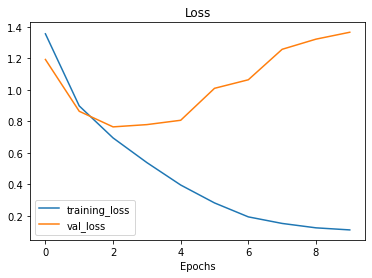

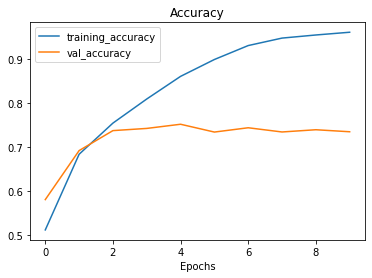

In [15]:
# VIEW THE LOSS CURVES
plot_loss_curves(history)

In [16]:
# EVALUATE THE MODEL
score = model.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 1.4645545482635498
Test Accuracy: 0.7161999940872192


จากกราฟ Loss จะพบว่า model มีปัญหา `Overfitting` ตั้งแต่แรก เมื่อวัดประสิทธิภาพในการ Predict ด้วย Test dataset ได้ค่า Accuracy 71.61%

In [17]:
# SAVE BASELINE MODEL
filepath = 'improve/baseline-model.h5'
model.save(filepath)

In [18]:
# CREATE MODEL WITH SHUFFLE IMAGE
model_1 = tf.keras.models.clone_model(model)

# COMPILE THE MODEL
model_1.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [19]:
# MODEL SUMMARY
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [20]:
# FIT THE MODEL
NO_EPOCHS = 10

history_1 = model_1.fit(X_train, y_train,
                   batch_size=BATCH_SIZE,
                   epochs=NO_EPOCHS,
                   shuffle=True,
                   verbose=1,
                   validation_data=(X_val, y_val),
                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/10
1250/1250 [==============================] - 9s 7ms/step - loss: 1.4520 - accuracy: 0.4722 - val_loss: 1.1075 - val_accuracy: 0.6012
Epoch 2/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.9871 - accuracy: 0.6488 - val_loss: 0.9294 - val_accuracy: 0.6710
Epoch 3/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.7673 - accuracy: 0.7297 - val_loss: 0.8210 - val_accuracy: 0.7145
Epoch 4/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.6037 - accuracy: 0.7875 - val_loss: 0.7823 - val_accuracy: 0.7320
Epoch 5/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.4594 - accuracy: 0.8391 - val_loss: 0.8322 - val_accuracy: 0.7287
Epoch 6/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.3311 - accuracy: 0.8842 - val_loss: 0.9441 - val_accuracy: 0.7251
Epoch 7/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.2363 - accuracy: 0.9158 - val_loss: 1.0222 - val_accuracy:

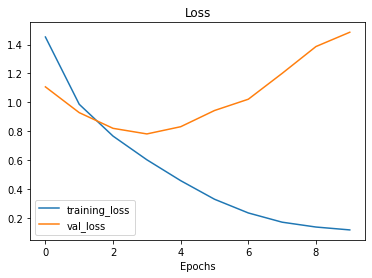

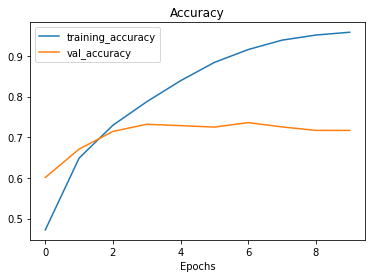

In [22]:
# VIEW THE LOSS CURVES
plot_loss_curves(history_1)

In [23]:
# EVALUATE THE MODEL
score = model_1.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 1.511411190032959
Test Accuracy: 0.7171000242233276


จากกราฟ Loss จะพบว่า model มีปัญหา `Overfitting` ตั้งแต่แรกเหมือนเดิม เมื่อวัดประสิทธิภาพในการ Predict ด้วย Test dataset ได้ค่า Accuracy 71.71% ซึ่งเพิ่มขึ้นมาจาก Baseline แค่ 0.10%

In [ ]:
# SAVE MODEL
filepath = 'improve/model_1-model.h5'
model_1.save(filepath)

# 3. TRY TO IMPROVE OVERFITTING BY IMAGE AUGMENTATION TECHNIQUE

ปัญหา `Overfitting` ของ model สามารถแก้ไขด้วยการเพิ่มจำนวน data ในการ train แต่ด้วย dataset ของเรามีจำนวนจำกัด ดังนั้น ในกรณีเราจึงต้องสังเคราะห์ data ขึ้นมาเอง ในกรณี data แบบ Image เราสามารถใช้เทคนิค `Image Augmentation` เพื่อทำการ หมุนภาพ เลื่อนภาพ กลับภาพ เป็นต้น
ซึ่งนอกจากจะเป็นการเพิ่มจำนวน data แล้ว Image Augmentation ยังช่วยเพิ่มความหลากหลายของภาพที่จะนำไป train อีกด้วย

In [34]:
# IMAGE AUGMENTATION
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=0.5, #Randomly rotate image in the range
                            zoom_range=0.2, # Randomly zoom image
                            width_shift_range=0.1, # Randomly shift images horizontally
                            height_shift_range=0.1, # Randomly shift images vertically
                             shear_range=0.5) # Random shear images
# Fit to training data
datagen.fit(X_train)

In [35]:
# DEFINE MODEL CNN
model_2 = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [36]:
# COMPILE THE MODEL
model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [37]:
# MODEL SUMMARY
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)             

In [38]:
# FIT THE MODEL
NO_EPOCHS = 10

history_2 = model_2.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, 
                       steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/10
1250/1250 [==============================] - 18s 14ms/step - loss: 1.5365 - accuracy: 0.4449 - val_loss: 1.2855 - val_accuracy: 0.5436
Epoch 2/10
1250/1250 [==============================] - 17s 14ms/step - loss: 1.1376 - accuracy: 0.5957 - val_loss: 0.9773 - val_accuracy: 0.6594
Epoch 3/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.9718 - accuracy: 0.6567 - val_loss: 0.9632 - val_accuracy: 0.6690
Epoch 4/10
1250/1250 [==============================] - 17s 13ms/step - loss: 0.8727 - accuracy: 0.6918 - val_loss: 0.8899 - val_accuracy: 0.7023
Epoch 5/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.8112 - accuracy: 0.7167 - val_loss: 0.7368 - val_accuracy: 0.7492
Epoch 6/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.7549 - accuracy: 0.7355 - val_loss: 0.7904 - val_accuracy: 0.7339
Epoch 7/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.7178 - accuracy: 0.7459 - val_loss: 0.7434 -

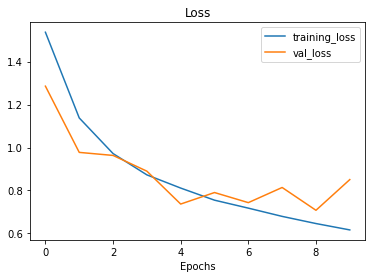

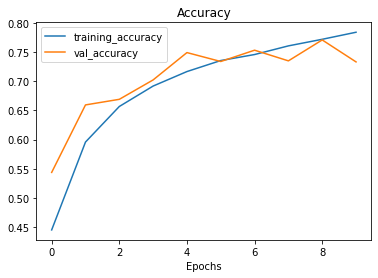

In [39]:
# PLOT LOSS CURVES
plot_loss_curves(history_2)

In [40]:
# EVALUATE THE MODEL_2
score = model_2.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.8893779516220093
Test Accuracy: 0.7200000286102295


จากกราฟ Loss ด้านบนจะเห็นว่า เมื่อมีการ Train ทั้งหมด 10 Epochs พบว่า Validation Loss ไม่พุ่งขึ้นตั้งแต่แรกๆ เหมือนในการ train แบบไม่ใช่ Image Augmentation เทคนิค เมื่อวัดประสิทธิภาพในการ Predict ด้วย Test dataset ได้ค่า `Accuracy 72%` แต่อย่างไรก็ตาม ในช่วงประมาณ epoch ที่ 10 Validation loss ยกสูงขึ้นอย่างเห็นได้ว่าเริ่มเกิดปัญหา `Overfitting`

In [31]:
# SAVE MODEL
filepath = 'improve/model_2-model.h5'
model_2.save(filepath)

# 4. TRY TO IMPROVE OVERFITTING BY BATCH NORMALIZATION TECHNIQUE

`BatchNormalization` เป็นเทคนิคในการทำ `Scaling Data` หรือเรียกว่าการทำ `Normalization` เพื่อปรับค่าข้อมูลให้อยู่ในขอบเขตที่กำหนด ก่อนส่งออกจาก Node ใน Neural Network Layer เป็น Input ของ Layer ถัดไปซึ่งเดิมเราจะทำ Normalization ในขั้นตอน Feature Engineering เช่น Normalize ด้วยการแปลงค่าสีของภาพแบบ GrayScale จาก 0-255 เป็น 0-1 โดยการนำค่าสีเดิมมาหารด้วย 255 เป็นต้น

นอกจากนี้ การทำ Data Normalization กับ feature อย่างช่น อายุ และเงินเดือน จะทำให้ ทั้ง 2 feature มีน้ำหนักที่เท่ากัน มีการกระจายตัวเหมือนกัน ไม่มีตัวไหนตัวหนึ่งตัวใดมีอิทธิพลมากกว่ากันทั้งยังเป็นการเพิ่มความเร็วในการ train model และทำให้ค่า loss ลดลงเมื่อเทียบกับตอนที่ยังไม่ได้ทำ Normalization เพราะมีค่าข้อมูลที่เล็กกว่า

In [41]:
# TRY TO USE BATCH NORMALIZATION
# BUILD THE MODEL_3
model_3 = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [42]:
# COMPILE THE MODEL
model_3.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [43]:
# MODEL SUMMARY
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)       

In [44]:
# FIT THE MODEL
NO_EPOCHS = 10

history_3 = model_3.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/10
1250/1250 [==============================] - 20s 15ms/step - loss: 1.4119 - accuracy: 0.5057 - val_loss: 1.1540 - val_accuracy: 0.6136
Epoch 2/10
1250/1250 [==============================] - 18s 15ms/step - loss: 1.0362 - accuracy: 0.6363 - val_loss: 1.0239 - val_accuracy: 0.6477
Epoch 3/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.8934 - accuracy: 0.6870 - val_loss: 0.8559 - val_accuracy: 0.7005
Epoch 4/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.8017 - accuracy: 0.7196 - val_loss: 0.7577 - val_accuracy: 0.7379
Epoch 5/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.7317 - accuracy: 0.7446 - val_loss: 0.8151 - val_accuracy: 0.7248
Epoch 6/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.6788 - accuracy: 0.7653 - val_loss: 0.9402 - val_accuracy: 0.7027
Epoch 7/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.6265 - accuracy: 0.7818 - val_loss: 0.7628 -

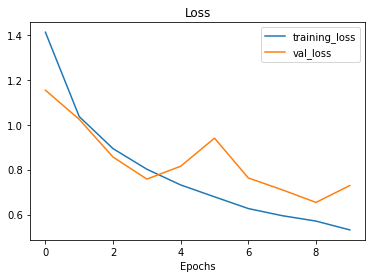

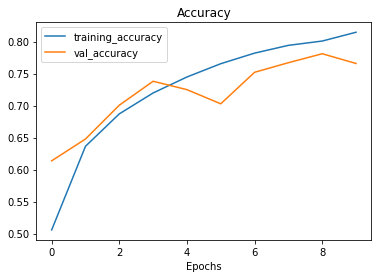

In [45]:
# VIEW THE LOSS CURVES
plot_loss_curves(history_3)

In [46]:
# EVALUATE THE MODEL_3
score = model_3.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.7232644557952881
Test Accuracy: 0.7723000049591064


จากกราฟ Loss พบว่า Training Loss มีแนวโน้มที่จะลดลง แต่ validation Loss คอนข้างแกว่งถึงแม้ว่า Accuracy จะเพิ่มขึ้นเป็น 77.23% ก็ตาม ฉะนั้นจึงอาจจะต้องใช้เทคนิคอื่นมาช่วยแก้ปัญหา `Overfitting `
ซึ่งมีเทคนิคหนึ่งที่มักนำมาใช้งานร่วมกันกับ `BatchNormalization` คือ `Dropout` เทคนิค

In [38]:
# SAVE MODEL
filepath = 'improve/model_3-model.h5'
model_3.save(filepath)

# 5. TRY TO IMPROVE OVERFITTING BY BATCH NORMALIZATION AND DROUPOUT TECHNIQUE

`Dropout` เป็นเทคนิคในการทำ Regularization ที่เรียบง่ายแต่มีประสิทธิภาพอย่างมาก โดยเมื่อมีการใช้งาน Dropout ภายใน Layer ที่กำหนด Node ใน Layer นั้นจะถูกสุ่มเพื่อปิดการทำงานชั่วคราวในแต่ละรอบของการทำงาน ในขณะที่ Train Model ทำให้ไม่มีการ Update Weight ใดๆ ที่ถูกเชื่อมต่อกับ Neuron Node ที่กำลังถูกปิด เราอาจจะมองการทำงานของ Dropout เหมือนกับการทำงานของบริษัทหนึ่งที่มีพนักงาน 100 คน 

- **ในกรณีที่ไม่มีการใช้** `Dropout` เปรียบได้กับการที่บริษัทมีนโยบายไม่อนุญาตให้พนักงานคนใดลาหยุดงาน ทำให้แต่ละคนต้องรับผิดชอบงานของตัวเองจนมีความเชี่ยวชาญเฉพาะด้าน สามารถแก้ปัญหาแบบเดิมๆ ที่เคยเรียนรู้มาแล้วเป็นอย่างดี แต่เมื่อเจอปัญหาใหม่ๆ พวกเขาจะไม่สามารถประยุกต์ใช้ความรู้ และทักษะความชำนาญเดิมมาแก้ปัญหาได้อย่างมีประสิทธิภาพ
- **ในกรณีที่มีการใช้** Dropout เปรียบได้กับการที่บริษัทมีนโยบายอนุญาให้พนักงานลาหยุดงานได้ ด้วยการสุ่มในอัตราที่กำหนด เช่น วันล่ะ 1 คน โดยคนที่ยังคงปฏิบัติต้องสลับกันมารับผิดชอบในหน้าที่ของพนักงานที่ได้หยุดพัก จนทำให้ทุกคนสามารถทำงานต่างๆ ทดแทนกันได้อย่างดี โดยไม่มีพนักงานคนใดมีอิทธิพลเหนือคนอื่น เมื่อเจอปัญหาใหม่ๆ พวกเขาจะสามารถประยุกต์ใช้ความรู้ และทักษะความชำนาญมาแก้ปัญหาได้อย่างมีประสิทธิภาพ
- **การใช้งานจริง** เราควรนำ Dropout มาใช้กับ `Model ที่มี Capacity สูงมากพอ` เช่นเดียวกับที่ควรนำไปใช้กับบริษัทที่มีพนักงานจำนวนมากๆ `โดยมีอัตราการ Dropout อยู่ในช่วงระหว่าง 0.2-0.5`

In [47]:
# TRY TO USE BATCH NORMALIZATION AND DROPOUT
# BUILD THE MODEL_4
model_4 = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [48]:
# COMPILE THE MODEL_4
model_4.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [49]:
# SUMMARY MODEL_4
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)       

ในการ Train Model รอบนี้อยากลองเพิ่ม Epoch ในการเทรนเป็น 200 จากเดิม 50 เพราะคาดว่า Validation Loss จะลดลงได้มากกว่าก่อนใช้ Dropout.

In [50]:
# FIT THE MODEL
NO_EPOCHS = 10

history_4 = model_4.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/10
1250/1250 [==============================] - 20s 15ms/step - loss: 1.7036 - accuracy: 0.3993 - val_loss: 1.4438 - val_accuracy: 0.4960
Epoch 2/10
1250/1250 [==============================] - 19s 15ms/step - loss: 1.3338 - accuracy: 0.5222 - val_loss: 1.0737 - val_accuracy: 0.6179
Epoch 3/10
1250/1250 [==============================] - 18s 14ms/step - loss: 1.1880 - accuracy: 0.5751 - val_loss: 0.9202 - val_accuracy: 0.6792
Epoch 4/10
1250/1250 [==============================] - 18s 14ms/step - loss: 1.0870 - accuracy: 0.6169 - val_loss: 0.9534 - val_accuracy: 0.6630
Epoch 5/10
1250/1250 [==============================] - 17s 14ms/step - loss: 1.0263 - accuracy: 0.6388 - val_loss: 0.9267 - val_accuracy: 0.6792
Epoch 6/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.9669 - accuracy: 0.6624 - val_loss: 0.9324 - val_accuracy: 0.6848
Epoch 7/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9206 - accuracy: 0.6740 - val_loss: 0.8087 -

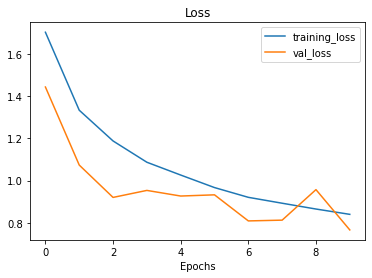

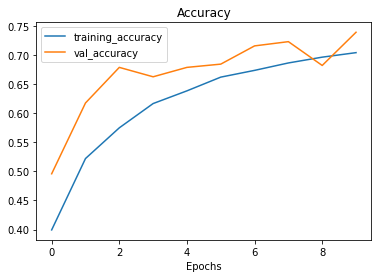

In [51]:
plot_loss_curves(history_4)

In [52]:
# EVALUATE THE MODEL_4
score = model_4.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.7798274755477905
Test Accuracy: 0.7325000166893005


ทำไม Accuracy Drop ?

จากกราฟ Loss ด้านบน จะเห็นได้ว่าหลังจากการ Train Model ที่ 200 Epochs พบว่า Validationi Loss ไม่พุ่งขึ้นจนเกิดปัญหา Overfitting 

In [45]:
# SAVE MODEL
filepath = 'improve/model_4-model.h5'
model_4.save(filepath)

ลอง Train model_3 & model_4 ที่ 50 epochs เพื่อดูความต่างให้ชัดเจนขึ้น

In [53]:
# Crate model_3 using 50 epochs
model_3_50epochs = tf.keras.models.clone_model(model_3)

# Compile the model
model_3_50epochs.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the model
NO_EPOCHS = 50

history_5 = model_3_50epochs.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/50
1250/1250 [==============================] - 19s 14ms/step - loss: 1.3986 - accuracy: 0.5103 - val_loss: 1.1504 - val_accuracy: 0.5978
Epoch 2/50
1250/1250 [==============================] - 18s 15ms/step - loss: 1.0473 - accuracy: 0.6326 - val_loss: 1.1157 - val_accuracy: 0.6188
Epoch 3/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.9082 - accuracy: 0.6806 - val_loss: 0.9028 - val_accuracy: 0.6890
Epoch 4/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.8014 - accuracy: 0.7201 - val_loss: 0.8038 - val_accuracy: 0.7251
Epoch 5/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.7346 - accuracy: 0.7433 - val_loss: 0.9159 - val_accuracy: 0.7033
Epoch 6/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6787 - accuracy: 0.7627 - val_loss: 0.8130 - val_accuracy: 0.7325
Epoch 7/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6425 - accuracy: 0.7753 - val_loss: 0.7476 -

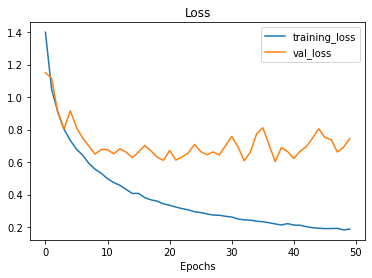

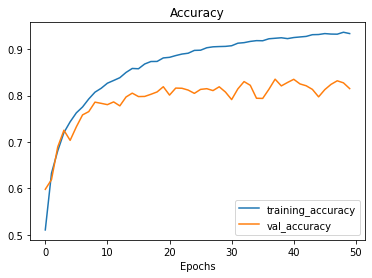

In [54]:
plot_loss_curves(history_5)

In [56]:
# EVALUATE THE MODEL_3_50EPOCHS
score = model_3_50epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.7677200436592102
Test Accuracy: 0.8095999956130981


In [ ]:
# SAVE MODEL
filepath = 'improve/model_3_50epoch-model.h5'
model_3_50epoch.save(filepath)

In [57]:
# Crate model_4 using 50 epochs
model_4_50epochs = tf.keras.models.clone_model(model_4)

# Compile the model
model_4_50epochs.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the model
NO_EPOCHS = 50

history_6 = model_4_50epochs.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.7210 - accuracy: 0.3971 - val_loss: 1.3205 - val_accuracy: 0.5270
Epoch 2/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.3424 - accuracy: 0.5173 - val_loss: 1.1674 - val_accuracy: 0.5955
Epoch 3/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.2004 - accuracy: 0.5690 - val_loss: 4.9420 - val_accuracy: 0.3997
Epoch 4/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.1127 - accuracy: 0.6050 - val_loss: 1.0261 - val_accuracy: 0.6442
Epoch 5/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.0299 - accuracy: 0.6347 - val_loss: 0.8320 - val_accuracy: 0.7090
Epoch 6/50
1250/1250 [==============================] - 18s 15ms/step - loss: 0.9762 - accuracy: 0.6545 - val_loss: 0.8510 - val_accuracy: 0.6968
Epoch 7/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9361 - accuracy: 0.6701 - val_loss: 0.8547 -

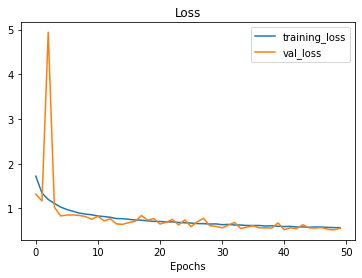

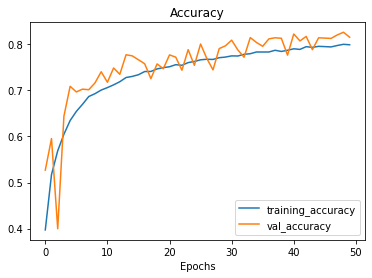

In [58]:
plot_loss_curves(history_6)

In [59]:
# EVALUATE THE MODEL_4_50EPOCHS
score = model_4_50epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5702386498451233
Test Accuracy: 0.8105999827384949


In [ ]:
# SAVE MODEL
filepath = 'improve/model_4_50epoch-model.h5'
model_4_50epochs.save(filepath)

จากกราฟ Loss ข้างบนจะเห็นว่า ในช่วงเริ่มต้นของการเทรน Model_4 ที่ 50 epoch นั้น (ช่วง epoch ที่ 1-5) Validation Loss มีการแกว่งตัว ยกสูงมาก แต่เมื่อเทรนนิ่งไป สักพัก กราฟก็จะต่ำลงมา ลดลงตาม Training Loss อย่างเห็นได้ชัด

เมื่อเทียบกับ Model_3 จะเห็นว่าช่วงแรกของ Model_3 นั้นอาจจะเริ่มต้นมาค่อยข้างดี โดยใน (ช่วง epochs ที่ 1-10 ) Validation Loss มีการลดลงอย่างเห็นได้ชัด แต่เมื่อผ่านไปสักระยะ Validation Loss ก็เริ่มยกตัวขึ้นและไม่ลดลงอีก

จะสังเกตุได้ว่า Accuracy จะต่างกันเพียง นิดเดียว แต่คาดว่าประสิทธิภาพ Model_4 จะดีกว่า

สรุปได้ว่า Model_4 นั้นมีประสิทธิภาพมากกว่า Model_3

ทดลองเทรน Model_4 ที่จำนวน epoch ที่ 200 ดูว่าจะมี Accuracy ที่ดีกว่าเดิมมากแค่ไหน ถ้าหากต้องใช้เวลาในการเทรนมากขึ้น ?

In [62]:
# Crate model_4 using 200 epochs
model_4_200epochs = tf.keras.models.clone_model(model_4)

# Compile the model
model_4_200epochs.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the model
NO_EPOCHS = 200

history_7 = model_4_200epochs.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/200
1250/1250 [==============================] - 20s 15ms/step - loss: 1.7113 - accuracy: 0.3984 - val_loss: 1.3609 - val_accuracy: 0.5175
Epoch 2/200
1250/1250 [==============================] - 17s 14ms/step - loss: 1.3376 - accuracy: 0.5219 - val_loss: 1.2887 - val_accuracy: 0.5720
Epoch 3/200
1250/1250 [==============================] - 18s 14ms/step - loss: 1.1804 - accuracy: 0.5754 - val_loss: 1.0454 - val_accuracy: 0.6424
Epoch 4/200
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0845 - accuracy: 0.6159 - val_loss: 1.2097 - val_accuracy: 0.6027
Epoch 5/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0055 - accuracy: 0.6446 - val_loss: 0.8028 - val_accuracy: 0.7161
Epoch 6/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.9682 - accuracy: 0.6583 - val_loss: 0.7955 - val_accuracy: 0.7231
Epoch 7/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9230 - accuracy: 0.6771 - val_loss: 0

1250/1250 [==============================] - 20s 16ms/step - loss: 0.5329 - accuracy: 0.8151 - val_loss: 0.5174 - val_accuracy: 0.8275
Epoch 57/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5393 - accuracy: 0.8116 - val_loss: 0.5013 - val_accuracy: 0.8314
Epoch 58/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5322 - accuracy: 0.8145 - val_loss: 0.5833 - val_accuracy: 0.8108
Epoch 59/200
1250/1250 [==============================] - 19s 16ms/step - loss: 0.5293 - accuracy: 0.8133 - val_loss: 0.4804 - val_accuracy: 0.8369
Epoch 60/200
1250/1250 [==============================] - 19s 16ms/step - loss: 0.5275 - accuracy: 0.8156 - val_loss: 0.5654 - val_accuracy: 0.8136
Epoch 61/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.5265 - accuracy: 0.8180 - val_loss: 0.5168 - val_accuracy: 0.8273
Epoch 62/200
1250/1250 [==============================] - 23s 19ms/step - loss: 0.5276 - accuracy: 0.8147 - val_loss: 0.4763 

1250/1250 [==============================] - 18s 14ms/step - loss: 0.4617 - accuracy: 0.8379 - val_loss: 0.5011 - val_accuracy: 0.8310
Epoch 112/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4589 - accuracy: 0.8371 - val_loss: 0.4985 - val_accuracy: 0.8373
Epoch 113/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4590 - accuracy: 0.8406 - val_loss: 0.4767 - val_accuracy: 0.8438
Epoch 114/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.4592 - accuracy: 0.8401 - val_loss: 0.4514 - val_accuracy: 0.8495
Epoch 115/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4503 - accuracy: 0.8401 - val_loss: 0.4605 - val_accuracy: 0.8451
Epoch 116/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4584 - accuracy: 0.8382 - val_loss: 0.4421 - val_accuracy: 0.8539
Epoch 117/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4588 - accuracy: 0.8400 - val_loss: 0

1250/1250 [==============================] - 19s 15ms/step - loss: 0.4457 - accuracy: 0.8430 - val_loss: 0.4990 - val_accuracy: 0.8372
Epoch 167/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4255 - accuracy: 0.8515 - val_loss: 0.4904 - val_accuracy: 0.8413
Epoch 168/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.4188 - accuracy: 0.8543 - val_loss: 0.4624 - val_accuracy: 0.8498
Epoch 169/200
1250/1250 [==============================] - 21s 17ms/step - loss: 0.4216 - accuracy: 0.8529 - val_loss: 0.4624 - val_accuracy: 0.8479
Epoch 170/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4207 - accuracy: 0.8526 - val_loss: 0.4546 - val_accuracy: 0.8531
Epoch 171/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.4170 - accuracy: 0.8532 - val_loss: 0.4616 - val_accuracy: 0.8483
Epoch 172/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4232 - accuracy: 0.8515 - val_loss: 0

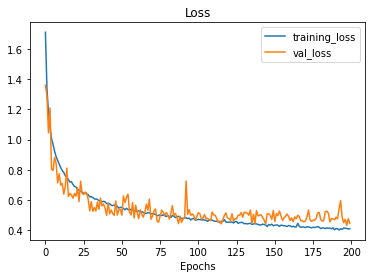

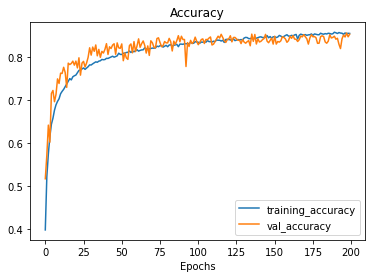

In [64]:
plot_loss_curves(history_7)

In [65]:
# EVALUATE THE MODEL_4_200EPOCHS
score = model_4_200epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.46526777744293213
Test Accuracy: 0.8522999882698059


จากกราฟ Loss ด้านบนพบว่า การ Train Model ที่ 200 epochs ทำให้โมเดลมี Accuracy เพิ่มมากขึ้น ถึง 4% เป็น 85.22% และ Validation Loss มีการลดลงอย่างต่อเนื่อง ไม่พุ่งจนเกิดปัญหา Overfitting

In [66]:
# SAVE MODEL
filepath = 'improve/model_4_200epoch-model.h5'
model_4_200epochs.save(filepath)

เอ้ะ แล้วถ้าปรับ Dropout ไล่ตามมาเป็น 0.2,0.3,0.4,0.5 จะเป็นยังไง ?

In [87]:
# TRY TO OPTIMIZE DROPOUT
# BUILD THE MODEL_4_optdropout
model_4_optdrop_200epochs = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.5),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [88]:
# Model Summary
model_4_optdrop_200epochs.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 16, 16, 32)       

In [89]:
# Compile the model
model_4_optdrop_200epochs.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [91]:
# Fit the model
NO_EPOCHS = 200

history_8 = model_4_optdrop_200epochs.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/200
1250/1250 [==============================] - 22s 17ms/step - loss: 1.2963 - accuracy: 0.5371 - val_loss: 1.6299 - val_accuracy: 0.5248
Epoch 2/200
1250/1250 [==============================] - 21s 17ms/step - loss: 1.2084 - accuracy: 0.5697 - val_loss: 1.1702 - val_accuracy: 0.5993
Epoch 3/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1474 - accuracy: 0.5950 - val_loss: 1.0523 - val_accuracy: 0.6422
Epoch 4/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0733 - accuracy: 0.6203 - val_loss: 1.0401 - val_accuracy: 0.6444
Epoch 5/200
1250/1250 [==============================] - 17s 14ms/step - loss: 1.0440 - accuracy: 0.6338 - val_loss: 0.9948 - val_accuracy: 0.6694
Epoch 6/200
1250/1250 [==============================] - 17s 13ms/step - loss: 1.0035 - accuracy: 0.6476 - val_loss: 0.9649 - val_accuracy: 0.6620
Epoch 7/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9815 - accuracy: 0.6542 - val_loss: 0

1250/1250 [==============================] - 17s 14ms/step - loss: 0.6845 - accuracy: 0.7596 - val_loss: 0.6064 - val_accuracy: 0.7911
Epoch 57/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6732 - accuracy: 0.7667 - val_loss: 0.6113 - val_accuracy: 0.7913
Epoch 58/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6800 - accuracy: 0.7643 - val_loss: 0.5411 - val_accuracy: 0.8121
Epoch 59/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6847 - accuracy: 0.7599 - val_loss: 0.5931 - val_accuracy: 0.7945
Epoch 60/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6718 - accuracy: 0.7663 - val_loss: 0.5705 - val_accuracy: 0.8036
Epoch 61/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6743 - accuracy: 0.7656 - val_loss: 0.5501 - val_accuracy: 0.8123
Epoch 62/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6653 - accuracy: 0.7695 - val_loss: 0.5703 

1250/1250 [==============================] - 17s 14ms/step - loss: 0.6247 - accuracy: 0.7826 - val_loss: 0.5198 - val_accuracy: 0.8211
Epoch 112/200
1250/1250 [==============================] - 17s 13ms/step - loss: 0.6209 - accuracy: 0.7846 - val_loss: 0.5354 - val_accuracy: 0.8141
Epoch 113/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6183 - accuracy: 0.7847 - val_loss: 0.5670 - val_accuracy: 0.8063
Epoch 114/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6197 - accuracy: 0.7829 - val_loss: 0.5501 - val_accuracy: 0.8143
Epoch 115/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6204 - accuracy: 0.7841 - val_loss: 0.5720 - val_accuracy: 0.8063
Epoch 116/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6165 - accuracy: 0.7862 - val_loss: 0.5032 - val_accuracy: 0.8274
Epoch 117/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.6191 - accuracy: 0.7844 - val_loss: 0

1250/1250 [==============================] - 17s 14ms/step - loss: 0.5909 - accuracy: 0.7953 - val_loss: 0.4650 - val_accuracy: 0.8399
Epoch 167/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5866 - accuracy: 0.7961 - val_loss: 0.5671 - val_accuracy: 0.8072
Epoch 168/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5930 - accuracy: 0.7941 - val_loss: 0.5167 - val_accuracy: 0.8236
Epoch 169/200
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5932 - accuracy: 0.7919 - val_loss: 0.5161 - val_accuracy: 0.8254
Epoch 170/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5937 - accuracy: 0.7946 - val_loss: 0.5064 - val_accuracy: 0.8280
Epoch 171/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5909 - accuracy: 0.7937 - val_loss: 0.4947 - val_accuracy: 0.8291
Epoch 172/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5949 - accuracy: 0.7934 - val_loss: 0

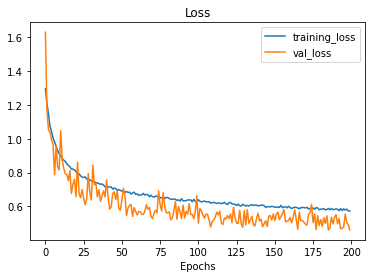

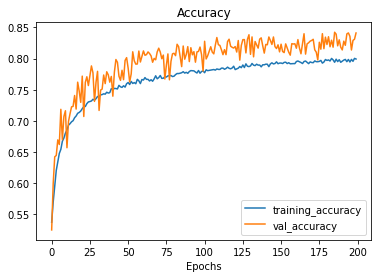

In [94]:
plot_loss_curves(history_8)

In [92]:
# EVALUATE THE MODEL_4_200EPOCHS
score = model_4_optdrop_200epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.47345346212387085
Test Accuracy: 0.833899974822998


In [93]:
# SAVE MODEL
filepath = 'improve/model_4_optdrop_200epochs-model.h5'
model_4_optdrop_200epochs.save(filepath)

Accuray ไม่เพิ่มขึ้น หรือว่า model_4 train 200 epochs จะดีกว่า ? ถ้าอย่างนั้นลองเทรนที่ 400 epoch ดูว่าค่าความแม่นยำมันเพิ่มขึ้นหรือไม่

In [96]:
# Crate model_4 using 400 epochs
model_4_400epochs = tf.keras.models.clone_model(model_4)

# Compile the model
model_4_400epochs.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the model
NO_EPOCHS = 400

history_9 = model_4_400epochs.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/400
1250/1250 [==============================] - 19s 14ms/step - loss: 1.7338 - accuracy: 0.3907 - val_loss: 1.3240 - val_accuracy: 0.5303
Epoch 2/400
1250/1250 [==============================] - 18s 14ms/step - loss: 1.3492 - accuracy: 0.5179 - val_loss: 1.0744 - val_accuracy: 0.6220
Epoch 3/400
1250/1250 [==============================] - 17s 13ms/step - loss: 1.1942 - accuracy: 0.5771 - val_loss: 1.8762 - val_accuracy: 0.4194
Epoch 4/400
1250/1250 [==============================] - 17s 13ms/step - loss: 1.1008 - accuracy: 0.6113 - val_loss: 1.0434 - val_accuracy: 0.6410
Epoch 5/400
1250/1250 [==============================] - 17s 14ms/step - loss: 1.0231 - accuracy: 0.6403 - val_loss: 0.8665 - val_accuracy: 0.6952
Epoch 6/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9781 - accuracy: 0.6545 - val_loss: 0.8200 - val_accuracy: 0.7145
Epoch 7/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9317 - accuracy: 0.6736 - val_loss: 0

1250/1250 [==============================] - 17s 14ms/step - loss: 0.5427 - accuracy: 0.8096 - val_loss: 0.5159 - val_accuracy: 0.8249
Epoch 57/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5375 - accuracy: 0.8135 - val_loss: 0.5694 - val_accuracy: 0.8181
Epoch 58/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5363 - accuracy: 0.8112 - val_loss: 0.5318 - val_accuracy: 0.8227
Epoch 59/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5320 - accuracy: 0.8127 - val_loss: 0.5090 - val_accuracy: 0.8309
Epoch 60/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.5352 - accuracy: 0.8145 - val_loss: 0.5216 - val_accuracy: 0.8286
Epoch 61/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5339 - accuracy: 0.8134 - val_loss: 0.5147 - val_accuracy: 0.8289
Epoch 62/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.5268 - accuracy: 0.8141 - val_loss: 0.4945 

1250/1250 [==============================] - 17s 13ms/step - loss: 0.4637 - accuracy: 0.8389 - val_loss: 0.5130 - val_accuracy: 0.8355
Epoch 112/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4625 - accuracy: 0.8383 - val_loss: 0.5158 - val_accuracy: 0.8359
Epoch 113/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4669 - accuracy: 0.8375 - val_loss: 0.4824 - val_accuracy: 0.8428
Epoch 114/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4585 - accuracy: 0.8386 - val_loss: 0.4772 - val_accuracy: 0.8494
Epoch 115/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4610 - accuracy: 0.8388 - val_loss: 0.5167 - val_accuracy: 0.8346
Epoch 116/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4595 - accuracy: 0.8389 - val_loss: 0.4742 - val_accuracy: 0.8475
Epoch 117/400
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4647 - accuracy: 0.8392 - val_loss: 0

1250/1250 [==============================] - 17s 14ms/step - loss: 0.4201 - accuracy: 0.8530 - val_loss: 0.5162 - val_accuracy: 0.8366
Epoch 167/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4251 - accuracy: 0.8493 - val_loss: 0.6034 - val_accuracy: 0.8167
Epoch 168/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4279 - accuracy: 0.8492 - val_loss: 0.5403 - val_accuracy: 0.8316
Epoch 169/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.4286 - accuracy: 0.8493 - val_loss: 0.4749 - val_accuracy: 0.8443
Epoch 170/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4213 - accuracy: 0.8519 - val_loss: 0.4653 - val_accuracy: 0.8522
Epoch 171/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4220 - accuracy: 0.8506 - val_loss: 0.4854 - val_accuracy: 0.8439
Epoch 172/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4232 - accuracy: 0.8515 - val_loss: 0

1250/1250 [==============================] - 17s 14ms/step - loss: 0.3985 - accuracy: 0.8609 - val_loss: 0.5411 - val_accuracy: 0.8342
Epoch 222/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4032 - accuracy: 0.8605 - val_loss: 0.4723 - val_accuracy: 0.8509
Epoch 223/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.4004 - accuracy: 0.8597 - val_loss: 0.4510 - val_accuracy: 0.8557
Epoch 224/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3969 - accuracy: 0.8614 - val_loss: 0.4540 - val_accuracy: 0.8534
Epoch 225/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4038 - accuracy: 0.8583 - val_loss: 0.4990 - val_accuracy: 0.8478
Epoch 226/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4069 - accuracy: 0.8566 - val_loss: 0.4627 - val_accuracy: 0.8534
Epoch 227/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.4117 - accuracy: 0.8569 - val_loss: 0

1250/1250 [==============================] - 17s 14ms/step - loss: 0.3811 - accuracy: 0.8659 - val_loss: 0.4805 - val_accuracy: 0.8513
Epoch 277/400
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3875 - accuracy: 0.8635 - val_loss: 0.4999 - val_accuracy: 0.8445
Epoch 278/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3936 - accuracy: 0.8613 - val_loss: 0.4660 - val_accuracy: 0.8526
Epoch 279/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3818 - accuracy: 0.8661 - val_loss: 0.4859 - val_accuracy: 0.8488
Epoch 280/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3858 - accuracy: 0.8650 - val_loss: 0.4975 - val_accuracy: 0.8445
Epoch 281/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3857 - accuracy: 0.8650 - val_loss: 0.4894 - val_accuracy: 0.8464
Epoch 282/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3864 - accuracy: 0.8653 - val_loss: 0

1250/1250 [==============================] - 17s 14ms/step - loss: 0.3725 - accuracy: 0.8718 - val_loss: 0.4783 - val_accuracy: 0.8522
Epoch 332/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3695 - accuracy: 0.8702 - val_loss: 0.5007 - val_accuracy: 0.8450
Epoch 333/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3711 - accuracy: 0.8705 - val_loss: 0.5126 - val_accuracy: 0.8422
Epoch 334/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3700 - accuracy: 0.8703 - val_loss: 0.4571 - val_accuracy: 0.8558
Epoch 335/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3665 - accuracy: 0.8704 - val_loss: 0.4571 - val_accuracy: 0.8538
Epoch 336/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3708 - accuracy: 0.8708 - val_loss: 0.5664 - val_accuracy: 0.8320
Epoch 337/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3659 - accuracy: 0.8705 - val_loss: 0

1250/1250 [==============================] - 17s 14ms/step - loss: 0.3642 - accuracy: 0.8712 - val_loss: 0.4857 - val_accuracy: 0.8488
Epoch 387/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3654 - accuracy: 0.8719 - val_loss: 0.4407 - val_accuracy: 0.8635
Epoch 388/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3675 - accuracy: 0.8706 - val_loss: 0.4379 - val_accuracy: 0.8634
Epoch 389/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3582 - accuracy: 0.8735 - val_loss: 0.4515 - val_accuracy: 0.8596
Epoch 390/400
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3629 - accuracy: 0.8750 - val_loss: 0.4582 - val_accuracy: 0.8572
Epoch 391/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3682 - accuracy: 0.8708 - val_loss: 0.4914 - val_accuracy: 0.8489
Epoch 392/400
1250/1250 [==============================] - 17s 13ms/step - loss: 0.3634 - accuracy: 0.8734 - val_loss: 0

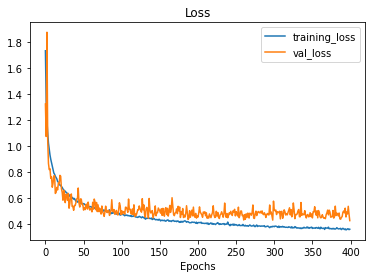

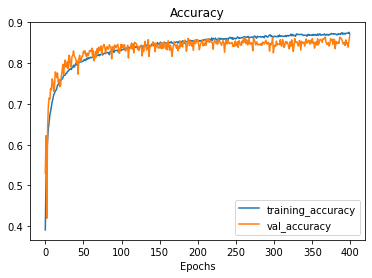

In [97]:
plot_loss_curves(history_9)

In [98]:
# EVALUATE THE MODEL_4_200EPOCHS
score = model_4_400epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.44196826219558716
Test Accuracy: 0.8590999841690063


In [99]:
# SAVE MODEL
filepath = 'improve/model_4_400epochs-model.h5'
model_4_400epochs.save(filepath)

200 เทียบกับ 400 Accuracy ต่างหันแค่ 0.7% เอง แสดงว่าตอนนี้ epochs เพิ่มขึ้นไม่ได้มีผลมากนัก

ทดลองปรับ Layer ลบ Dropout ใน CNN LAYER แรกออก (อาจจะเป็นสาเหตุให้ Validation Loss กระโดดสูงขึ้นมาในช่วงแรกของการเทรน)
และ เพิ่ม kernel_initializer='he_uniform' เพิ่มชั้น 5 และ 6 เข้าไป ที่ โดยมี filter=128 และ มีการปรับ dropout แบบปรับไล่เพิ่มลงมา (เพราะเห็นว่าจากการทดลองปรับก่อนหน้านี้มันทำให้เส้น Validation Loss วิ่งต่ำกว่า Training Loss อย่างเห็นได้ชัด

**He initialisation**

วิธีเป็นวิธีสุ่มจาก Uniform distribution คือกระจายตัวออกเท่าๆ กันตลอด Range ของข้อมูล เราสามารถจะเลือกสุ่มแบบ Normal distribution คือกระจายการสุ่มให้กระจุกตัวเยอะตรงกลางๆ ของ Range ก็ได้ โดยการเปลี่ยนแปลงสมการเล็กน้อย ทั้งนี้ใน TensorFlow เราสามารถกำหนดวิธีการ Initialise ค่าน้ำหนักได้โดยใช้ Argument kernel_initializer ใน Layer

ปัจจุบัน แนะนำให้ใช้ He initialiser เพราะออกแบบมาให้ใช้กับ Activation function ตระกูล ReLU และ ELU

In [100]:
# TRY TO USE BATCH NORMALIZATION AND DROPOUT
# BUILD THE MODEL_4
model_4_opt = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    # 5. CNN LAYER
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # 6. CNN LAYER
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [101]:
# Compile the model
model_4_opt.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the model
NO_EPOCHS = 10

history_10 = model_4_opt.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/10
1250/1250 [==============================] - 19s 14ms/step - loss: 1.8451 - accuracy: 0.3709 - val_loss: 1.4414 - val_accuracy: 0.4960
Epoch 2/10
1250/1250 [==============================] - 18s 14ms/step - loss: 1.3452 - accuracy: 0.5160 - val_loss: 1.0756 - val_accuracy: 0.6201
Epoch 3/10
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1586 - accuracy: 0.5881 - val_loss: 1.2731 - val_accuracy: 0.5648
Epoch 4/10
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0379 - accuracy: 0.6327 - val_loss: 0.9189 - val_accuracy: 0.6773
Epoch 5/10
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9518 - accuracy: 0.6649 - val_loss: 0.9263 - val_accuracy: 0.6779
Epoch 6/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.8859 - accuracy: 0.6917 - val_loss: 0.9063 - val_accuracy: 0.7020
Epoch 7/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.8293 - accuracy: 0.7135 - val_loss: 0.7118 -

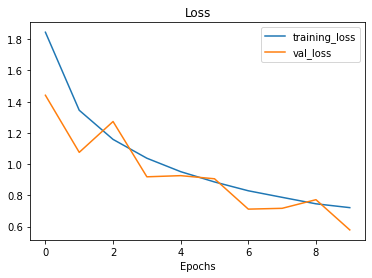

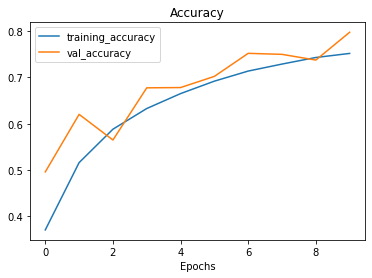

In [102]:
plot_loss_curves(history_10)

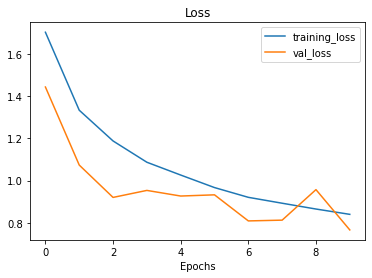

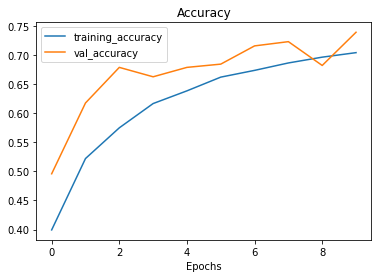

In [103]:
plot_loss_curves(history_4)

In [104]:
# EVALUATE THE MODEL_4_200EPOCHS
score = model_4_opt.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5981800556182861
Test Accuracy: 0.792900025844574


In [105]:
# EVALUATE THE MODEL_4_200EPOCHS
score = model_4.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.7798274755477905
Test Accuracy: 0.7325000166893005


Model_4_opt ปรับ Layer ใหม่เพิ่ม kernel_initializer='he_uniform' เพิ่มชั้น 5 และ 6 เข้าไป ดีกว่า Model_4 เดิมๆมาก

In [126]:
# SAVE MODEL
filepath = 'improve/model_4_opt-model.h5'
model_4_opt.save(filepath)

ทดลอง Train model_4_opt ที่ 50 epochs

In [107]:
# Crate model_4 using 50 epochs
model_4_opt_50epochs = tf.keras.models.clone_model(model_4_opt)

# Compile the model
model_4_opt_50epochs.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the model
NO_EPOCHS = 50

history_11 = model_4_opt_50epochs.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/50
1250/1250 [==============================] - 19s 14ms/step - loss: 1.8104 - accuracy: 0.3817 - val_loss: 1.4624 - val_accuracy: 0.4935
Epoch 2/50
1250/1250 [==============================] - 19s 15ms/step - loss: 1.3248 - accuracy: 0.5240 - val_loss: 1.1854 - val_accuracy: 0.5936
Epoch 3/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.1525 - accuracy: 0.5906 - val_loss: 0.9937 - val_accuracy: 0.6489
Epoch 4/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.0382 - accuracy: 0.6349 - val_loss: 1.0402 - val_accuracy: 0.6633
Epoch 5/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.9590 - accuracy: 0.6641 - val_loss: 0.8921 - val_accuracy: 0.6902
Epoch 6/50
1250/1250 [==============================] - 21s 17ms/step - loss: 0.8813 - accuracy: 0.6951 - val_loss: 0.6947 - val_accuracy: 0.7552
Epoch 7/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.8224 - accuracy: 0.7137 - val_loss: 0.7326 -

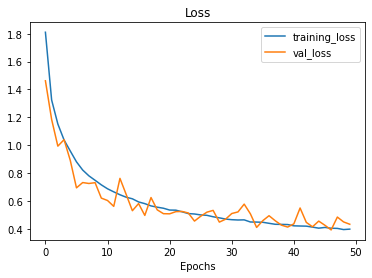

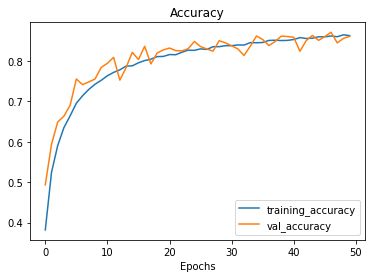

In [108]:
plot_loss_curves(history_11)

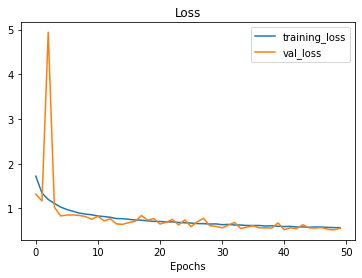

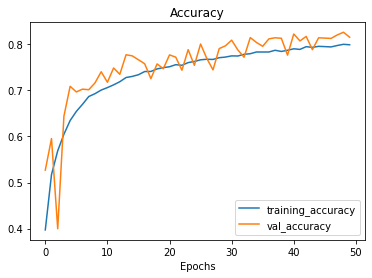

In [109]:
plot_loss_curves(history_6)

In [110]:
# EVALUATE THE model_4_opt_50epochs
score = model_4_opt_50epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.4645448327064514
Test Accuracy: 0.8507000207901001


In [111]:
# model_4_50epochs
# EVALUATE THE MODEL_4_200EPOCHS
score = model_4_50epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5702386498451233
Test Accuracy: 0.8105999827384949


ดีกว่า model_4 ที่ Train 50 epochs แล้วไหนลองเทียบกับ  model_4_200epoch ว่าจะต่างกับ model_4_opt ที่่ train เพียง 50 epochs แค่ไหน

In [112]:
# model_4_50epochs
# EVALUATE THE MODEL_4_200EPOCHS
score = model_4_200epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.46526777744293213
Test Accuracy: 0.8522999882698059


ว้าว ต่างกันแค่ 0.2% เอง แถมไม่ Overfitting ด้วย และเหมือนจะ Validation Loss จะไต่ลงเรื่อยๆอีกด้วย

In [135]:
# SAVE MODEL
filepath = 'improve/model_4_opt_50epochs-model.h5'
model_4_opt_50epochs.save(filepath)

ถ้าอย่างนั้น ลอง Train model_4_opt ที่ 200 epochs เพื่อทดสอบว่ามันจะดีจริงๆ กว่า model_4 ที่ 200 epochs มั้ยในเมื่อเทรนแค่ 50 epochs ได้เรียกว่าแทบจะเท่ากันเลย ?

In [114]:
# Crate model_4 using 200 epochs
model_4_opt_200epochs = tf.keras.models.clone_model(model_4_opt)

# Compile the model
model_4_opt_200epochs.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit the model
NO_EPOCHS = 200

history_12 = model_4_opt_200epochs.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/200
1250/1250 [==============================] - 20s 15ms/step - loss: 1.8019 - accuracy: 0.3837 - val_loss: 1.4086 - val_accuracy: 0.4935
Epoch 2/200
1250/1250 [==============================] - 18s 14ms/step - loss: 1.2946 - accuracy: 0.5369 - val_loss: 1.7154 - val_accuracy: 0.5011
Epoch 3/200
1250/1250 [==============================] - 18s 14ms/step - loss: 1.1280 - accuracy: 0.6008 - val_loss: 0.9389 - val_accuracy: 0.6681
Epoch 4/200
1250/1250 [==============================] - 18s 15ms/step - loss: 1.0041 - accuracy: 0.6464 - val_loss: 0.8584 - val_accuracy: 0.6995
Epoch 5/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9337 - accuracy: 0.6744 - val_loss: 1.0461 - val_accuracy: 0.6480
Epoch 6/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.8728 - accuracy: 0.6963 - val_loss: 0.8414 - val_accuracy: 0.7041
Epoch 7/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.8195 - accuracy: 0.7162 - val_loss: 0

1250/1250 [==============================] - 18s 14ms/step - loss: 0.3740 - accuracy: 0.8697 - val_loss: 0.5618 - val_accuracy: 0.8296
Epoch 57/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3708 - accuracy: 0.8708 - val_loss: 0.4352 - val_accuracy: 0.8590
Epoch 58/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3764 - accuracy: 0.8697 - val_loss: 0.4778 - val_accuracy: 0.8473
Epoch 59/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3650 - accuracy: 0.8733 - val_loss: 0.5072 - val_accuracy: 0.8445
Epoch 60/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3689 - accuracy: 0.8733 - val_loss: 0.4339 - val_accuracy: 0.8626
Epoch 61/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3664 - accuracy: 0.8730 - val_loss: 0.4868 - val_accuracy: 0.8451
Epoch 62/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3633 - accuracy: 0.8760 - val_loss: 0.4955 

1250/1250 [==============================] - 20s 16ms/step - loss: 0.2921 - accuracy: 0.8989 - val_loss: 0.5334 - val_accuracy: 0.8488
Epoch 112/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2955 - accuracy: 0.8960 - val_loss: 0.4206 - val_accuracy: 0.8714
Epoch 113/200
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2894 - accuracy: 0.9005 - val_loss: 0.4278 - val_accuracy: 0.8682
Epoch 114/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2894 - accuracy: 0.8997 - val_loss: 0.4558 - val_accuracy: 0.8644
Epoch 115/200
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2964 - accuracy: 0.8973 - val_loss: 0.4211 - val_accuracy: 0.8685
Epoch 116/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.2887 - accuracy: 0.8986 - val_loss: 0.3869 - val_accuracy: 0.8799
Epoch 117/200
1250/1250 [==============================] - 22s 17ms/step - loss: 0.2900 - accuracy: 0.8989 - val_loss: 0

1250/1250 [==============================] - 22s 17ms/step - loss: 0.2619 - accuracy: 0.9082 - val_loss: 0.3971 - val_accuracy: 0.8835
Epoch 167/200
1250/1250 [==============================] - 25s 20ms/step - loss: 0.2540 - accuracy: 0.9104 - val_loss: 0.4155 - val_accuracy: 0.8769
Epoch 168/200
1250/1250 [==============================] - 22s 18ms/step - loss: 0.2561 - accuracy: 0.9104 - val_loss: 0.4109 - val_accuracy: 0.8784
Epoch 169/200
1250/1250 [==============================] - 23s 18ms/step - loss: 0.2596 - accuracy: 0.9098 - val_loss: 0.4002 - val_accuracy: 0.8827
Epoch 170/200
1250/1250 [==============================] - 23s 19ms/step - loss: 0.2464 - accuracy: 0.9135 - val_loss: 0.3968 - val_accuracy: 0.8793
Epoch 171/200
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2587 - accuracy: 0.9107 - val_loss: 0.3924 - val_accuracy: 0.8858
Epoch 172/200
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2483 - accuracy: 0.9135 - val_loss: 0

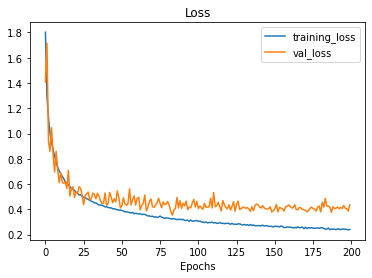

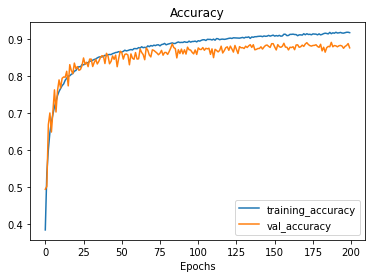

In [115]:
plot_loss_curves(history_12)

In [116]:
# model_4_opt_200epochs
# EVALUATE THE model_4_opt_200epochs
score = model_4_opt_200epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.45757293701171875
Test Accuracy: 0.8712999820709229


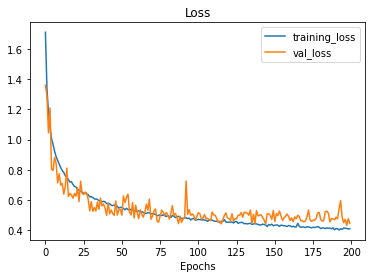

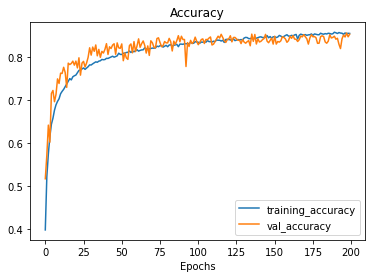

In [118]:
plot_loss_curves(history_7)

In [119]:
# EVALUATE THE MODEL_4_200EPOCHS
score = model_4_200epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.46526777744293213
Test Accuracy: 0.8522999882698059


wow look like much better, Accuracy เพิ่มขึ้นมา 1.9% เป็น 87.12% แต่เหมือนว่า ค่า validation loss จะแกว่งไปมาตั้งแต่ epochs ที่ 150

In [136]:
# SAVE MODEL
filepath = 'improve/model_4_opt_200epochs-model.h5'
model_4_opt_200epochs.save(filepath)

### ทดลองเพิ่ม kernel_regularizer=regularizers.l2(1e-4) 0.0001 เข้าไปใน Layer

**Regularisation** คือเทคนิคในการลดปัญหา Variance ของโมเดล นั่นก็คือการที่โมเดลถูกเทรนแล้วฟิตกับข้อมูลชุด Train set ได้ดี แต่พยากรณ์ไม่แม่นยำเมื่อนำไปใช้กับ Test set หรือข้อมูลจริงที่โมเดลไม่เคยเห็น บางทีเราเรียกปัญหานี้ว่า Generalisation error

**L2 regularisation**
แนวทางพื้นฐานในการแก้ปัญหา Generalisation error คือการเพิ่ม Regularisation term เข้าไปใน Cost function และในการอัปเดต Parameter เพื่อกดค่า w ให้น้อยลง และ ค่าของ Regularisation term นี้ จะแปรผันตามความซับซ้อนของโมเดล

การ Regularise ด้วยวิธีนี้ เป็นวิธีทั่วไปที่ใช้ในสถิติและ Machine learning algorithm อื่นๆ อย่างไรก็ตาม เมื่อใช้กับ Deep neural network l2 regularisation มีปัญหาอันหนึ่ง คือปรากฏการณ์ Co-adaptation กล่าวคือมันทำให้ค่าน้ำหนักที่มีค่ามาก ยิ่งขยายขนาด ส่วนค่าน้ำหนักที่มีค่าน้อย ยิ่งลดขนาด นั่นก็คือการขยายความต่างนั่นเอง ปรากฏการณ์นี้ทำให้เราไม่สามารถใช้ประโยชน์จากโมเดลที่มีความซับซ้อนมากขึ้นได้เต็มที่ เพราะเมื่อเราทำให้โมเดลซับซ้อนขึ้น ผลที่ได้กลับเป็นโมเดลที่เน้นสิ่งที่มีค่ามาก และกดสิ่งที่มีค่าน้อยลงอย่างเป็นระบบ

### Create model_4_opt_reg

In [121]:
# BUILD THE MODEL
model_4_opt_reg = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(1e-4), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(1e-4), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(1e-4), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(1e-4), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    # 5. CNN LAYER
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(1e-4), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # 6. CNN LAYER
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(1e-4), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [123]:
# Compile the model
model_4_opt_reg.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [124]:
# Model Summary
model_4_opt_reg.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)       

### ในการเทรนรอบนี้จะลองใช้ Early Stopper ดู

In [129]:
# DEFINE CALLBACKS PARAMETERS
rlr = ReduceLROnPlateau(monitor='val_accuracy', mode ='max', factor=0.5, min_lr=1e-7, verbose = 1, patience=10)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience=50, restore_best_weights=True)
mc = ModelCheckpoint('improve/cnn_best_model.h5', monitor='val_accuracy', mode='max', verbose = 1, save_best_only=True)
callback_list = [rlr, es, mc]

**ModelCheckpoint**: ใช้ในการทำ Save Model ที่ดีที่สุดในทุกรอบของการ Modeling นามสกุลก็จะเป็น .h5 เฉพาะ Packages Keras เท่านั้น


**Early stopping**: คือการหยุดการเทรนก่อนที่ Optimiser จะ Converge หา Loss ที่ต่ำที่สุด โดยมีสมมุติฐานว่ายิ่งเทรนไป โมเดลจะยิ่งซับซ้อนขึ้น จนอาจจะเกินจากที่จะสามารถ Generalise ได้ดี จะเห็นว่า ตามปกติ Optimiser จะเทรนเพื่อให้ได้ Train error ต่ำที่สุด แต่บางครั้ง Test error จะเริ่มวกกลับไปมีค่าสูงขึ้นก่อนที่จะพบจุดต่ำสุดของ Cost function ดังนั้น เราควรจะหยุดการเทรนที่จุดที่ Test error ต่ำที่สุด ไม่ใช่ Train error ต่ำที่สุด

**ReduceLROnPlateau**: ใช้ในการลด Learning Rate (ความเร็วในการค้นหาจุดไหนคือ Global Minima)
- monitor= ’val_accuracy’: ใช้ Criteria อะไรในการลด Learning Rate
- patience= 10: ทนรอได้กี่ epoch ก่อนที่จะทำการลดค่า learning rate
- verbose= 1: รูปแบบการแสดงผลหากเกิด Effect
- factor= 0.5: หากไม่สามารถลด loss ได้ใน 10 epoch ทำการลด learning rate 50%

In [130]:
# FIT THE MODEL
NO_EPOCHS = 200

history_13 = model_4_opt_reg.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                       callbacks=callback_list)

Epoch 1/200
1250/1250 [==============================] - 21s 17ms/step - loss: 1.1355 - accuracy: 0.6381 - val_loss: 0.9534 - val_accuracy: 0.7067

Epoch 00001: val_accuracy improved from -inf to 0.70670, saving model to improve\cnn_best_model.h5
Epoch 2/200
1250/1250 [==============================] - 21s 17ms/step - loss: 1.0670 - accuracy: 0.6668 - val_loss: 0.9652 - val_accuracy: 0.7068

Epoch 00002: val_accuracy improved from 0.70670 to 0.70680, saving model to improve\cnn_best_model.h5
Epoch 3/200
1250/1250 [==============================] - 21s 17ms/step - loss: 1.0184 - accuracy: 0.6914 - val_loss: 0.9876 - val_accuracy: 0.7084

Epoch 00003: val_accuracy improved from 0.70680 to 0.70840, saving model to improve\cnn_best_model.h5
Epoch 4/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9683 - accuracy: 0.7136 - val_loss: 0.9266 - val_accuracy: 0.7338

Epoch 00004: val_accuracy improved from 0.70840 to 0.73380, saving model to improve\cnn_best_model.h5
Epo


Epoch 00037: val_accuracy did not improve from 0.85950
Epoch 38/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.5995 - accuracy: 0.8550 - val_loss: 0.7266 - val_accuracy: 0.8235

Epoch 00038: val_accuracy did not improve from 0.85950
Epoch 39/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5994 - accuracy: 0.8521 - val_loss: 0.6361 - val_accuracy: 0.8426

Epoch 00039: val_accuracy did not improve from 0.85950
Epoch 40/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.5942 - accuracy: 0.8545 - val_loss: 0.5698 - val_accuracy: 0.8665

Epoch 00040: val_accuracy improved from 0.85950 to 0.86650, saving model to improve\cnn_best_model.h5
Epoch 41/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5902 - accuracy: 0.8550 - val_loss: 0.6161 - val_accuracy: 0.8516

Epoch 00041: val_accuracy did not improve from 0.86650
Epoch 42/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0

1250/1250 [==============================] - 25s 20ms/step - loss: 0.4178 - accuracy: 0.9011 - val_loss: 0.5326 - val_accuracy: 0.8751

Epoch 00075: val_accuracy did not improve from 0.88690
Epoch 76/200
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4229 - accuracy: 0.8988 - val_loss: 0.5157 - val_accuracy: 0.8791

Epoch 00076: val_accuracy did not improve from 0.88690
Epoch 77/200
1250/1250 [==============================] - 26s 21ms/step - loss: 0.4102 - accuracy: 0.9042 - val_loss: 0.5260 - val_accuracy: 0.8762

Epoch 00077: val_accuracy did not improve from 0.88690
Epoch 78/200
1250/1250 [==============================] - 27s 21ms/step - loss: 0.4119 - accuracy: 0.9012 - val_loss: 0.4888 - val_accuracy: 0.8853

Epoch 00078: val_accuracy did not improve from 0.88690
Epoch 79/200
1250/1250 [==============================] - 27s 21ms/step - loss: 0.4083 - accuracy: 0.9032 - val_loss: 0.5206 - val_accuracy: 0.8778

Epoch 00079: val_accuracy did not improve from 0

1250/1250 [==============================] - 19s 15ms/step - loss: 0.3496 - accuracy: 0.9171 - val_loss: 0.4973 - val_accuracy: 0.8825

Epoch 00114: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00114: val_accuracy did not improve from 0.88850
Epoch 115/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3518 - accuracy: 0.9162 - val_loss: 0.4831 - val_accuracy: 0.8850

Epoch 00115: val_accuracy did not improve from 0.88850
Epoch 116/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3544 - accuracy: 0.9158 - val_loss: 0.4805 - val_accuracy: 0.8860

Epoch 00116: val_accuracy did not improve from 0.88850
Epoch 117/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3464 - accuracy: 0.9195 - val_loss: 0.4916 - val_accuracy: 0.8844

Epoch 00117: val_accuracy did not improve from 0.88850
Epoch 118/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3484 - accuracy: 0.9178 - val_

1250/1250 [==============================] - 20s 16ms/step - loss: 0.3302 - accuracy: 0.9224 - val_loss: 0.4846 - val_accuracy: 0.8880

Epoch 00152: val_accuracy did not improve from 0.88950
Epoch 153/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3320 - accuracy: 0.9218 - val_loss: 0.4776 - val_accuracy: 0.8894

Epoch 00153: val_accuracy did not improve from 0.88950
Epoch 154/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3270 - accuracy: 0.9222 - val_loss: 0.4874 - val_accuracy: 0.8869

Epoch 00154: val_accuracy did not improve from 0.88950
Epoch 155/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3262 - accuracy: 0.9228 - val_loss: 0.4817 - val_accuracy: 0.8883

Epoch 00155: val_accuracy did not improve from 0.88950
Epoch 156/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3247 - accuracy: 0.9228 - val_loss: 0.4771 - val_accuracy: 0.8886

Epoch 00156: val_accuracy did not improve fr


Epoch 00190: val_accuracy did not improve from 0.88980
Epoch 191/200
1250/1250 [==============================] - 17s 14ms/step - loss: 0.3145 - accuracy: 0.9276 - val_loss: 0.4823 - val_accuracy: 0.8879

Epoch 00191: val_accuracy did not improve from 0.88980
Epoch 192/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3182 - accuracy: 0.9268 - val_loss: 0.4808 - val_accuracy: 0.8877

Epoch 00192: val_accuracy did not improve from 0.88980
Epoch 193/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3246 - accuracy: 0.9228 - val_loss: 0.4783 - val_accuracy: 0.8881

Epoch 00193: val_accuracy did not improve from 0.88980
Epoch 194/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3192 - accuracy: 0.9263 - val_loss: 0.4799 - val_accuracy: 0.8883

Epoch 00194: val_accuracy did not improve from 0.88980
Epoch 195/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3292 - accuracy: 0.9235 - val_loss: 0.477

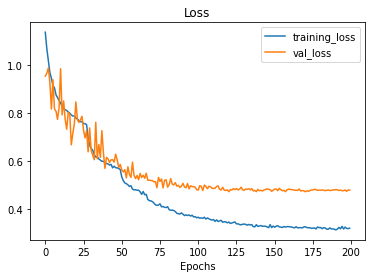

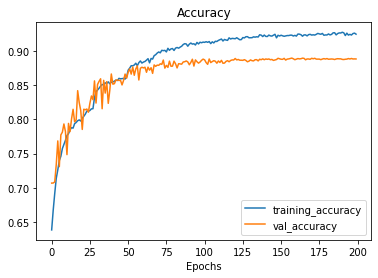

In [131]:
plot_loss_curves(history_13)

In [132]:
# EVALUATE THE model_4_opt_reg 200 epochs
score = model_4_opt_reg.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.5088397264480591
Test Accuracy: 0.8816999793052673


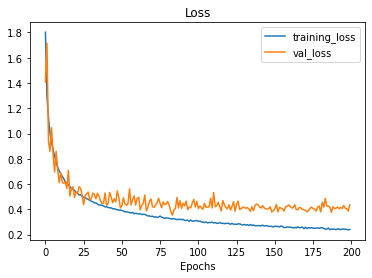

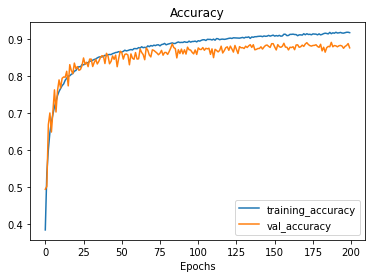

In [133]:
plot_loss_curves(history_12)

In [134]:
# model_4_opt_200epochs
# EVALUATE THE model_4_opt_200epochs
score = model_4_opt_200epochs.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.45757293701171875
Test Accuracy: 0.8712999820709229


จะเห็นว่ากราฟ Loss ของ `Model_4_opt_reg` จะมีความแกว่งน้อยลงแต่ยังไม่สามารถ ลดลงได้ต่ำกว่า `model_4_opt_200epochs`
และ เห็นได้ว่า Accuracy เพิ่มขึ้น 1.04% แต่ Loss ก็เพิ่มขึ้น 5% เช่นกัน

In [137]:
# SAVE MODEL
filepath = 'improve/model_4_opt_reg-model.h5'
model_4_opt_reg.save(filepath)

### เหลืออะไรบ้างที่ยังไม่ได้ทดลอง optimize ?

Adam Optimizers ? 

แล้ว Adam Optimizers ทำอะไรได้บ้าง
- hyperparameters '**Learning Rate**' , '**decay**'

note: https://cs231n.github.io/neural-networks-3/#ada

In [140]:
# Crate model_4 using 200 epochs
model_4_opt_lr = tf.keras.models.clone_model(model_4_opt_reg)


# Compile the model
model_4_opt_lr.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, 
                                                              epsilon = 1e-8, 
                                                              beta_1 = 0.9, 
                                                              beta_2 = 0.999),
                           metrics=['accuracy'])

In [141]:
# Fit the model
NO_EPOCHS = 200

history_14 = model_4_opt_lr.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                       callbacks=callback_list)

Epoch 1/200
1250/1250 [==============================] - 21s 16ms/step - loss: 1.9101 - accuracy: 0.3783 - val_loss: 1.7984 - val_accuracy: 0.4154

Epoch 00001: val_accuracy did not improve from 0.88980
Epoch 2/200
1250/1250 [==============================] - 18s 14ms/step - loss: 1.4401 - accuracy: 0.5165 - val_loss: 1.1887 - val_accuracy: 0.6110

Epoch 00002: val_accuracy did not improve from 0.88980
Epoch 3/200
1250/1250 [==============================] - 19s 15ms/step - loss: 1.2558 - accuracy: 0.5911 - val_loss: 1.2168 - val_accuracy: 0.6136

Epoch 00003: val_accuracy did not improve from 0.88980
Epoch 4/200
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1441 - accuracy: 0.6350 - val_loss: 1.1411 - val_accuracy: 0.6497

Epoch 00004: val_accuracy did not improve from 0.88980
Epoch 5/200
1250/1250 [==============================] - 18s 14ms/step - loss: 1.0681 - accuracy: 0.6680 - val_loss: 0.9128 - val_accuracy: 0.7223

Epoch 00005: val_accuracy did not improv

1250/1250 [==============================] - 20s 16ms/step - loss: 0.7259 - accuracy: 0.8264 - val_loss: 0.7873 - val_accuracy: 0.8124

Epoch 00041: val_accuracy did not improve from 0.88980
Epoch 42/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.7282 - accuracy: 0.8268 - val_loss: 0.7285 - val_accuracy: 0.8275

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00042: val_accuracy did not improve from 0.88980
Epoch 43/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.6718 - accuracy: 0.8420 - val_loss: 0.6563 - val_accuracy: 0.8536

Epoch 00043: val_accuracy did not improve from 0.88980
Epoch 44/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.6407 - accuracy: 0.8511 - val_loss: 0.6949 - val_accuracy: 0.8368

Epoch 00044: val_accuracy did not improve from 0.88980
Epoch 45/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.6229 - accuracy: 0.8541 - val_loss

1250/1250 [==============================] - 20s 16ms/step - loss: 0.4331 - accuracy: 0.8967 - val_loss: 0.5094 - val_accuracy: 0.8773

Epoch 00080: val_accuracy did not improve from 0.88980
Epoch 81/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4293 - accuracy: 0.8977 - val_loss: 0.5021 - val_accuracy: 0.8809

Epoch 00081: val_accuracy did not improve from 0.88980
Epoch 82/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4210 - accuracy: 0.9003 - val_loss: 0.5078 - val_accuracy: 0.8806

Epoch 00082: val_accuracy did not improve from 0.88980
Epoch 83/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.4169 - accuracy: 0.9018 - val_loss: 0.4944 - val_accuracy: 0.8843

Epoch 00083: val_accuracy did not improve from 0.88980
Epoch 84/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.4203 - accuracy: 0.8994 - val_loss: 0.5065 - val_accuracy: 0.8813

Epoch 00084: val_accuracy did not improve from 0

1250/1250 [==============================] - 19s 15ms/step - loss: 0.3533 - accuracy: 0.9187 - val_loss: 0.4801 - val_accuracy: 0.8878

Epoch 00119: val_accuracy did not improve from 0.88980
Epoch 120/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3521 - accuracy: 0.9190 - val_loss: 0.4851 - val_accuracy: 0.8866

Epoch 00120: val_accuracy did not improve from 0.88980
Epoch 121/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3529 - accuracy: 0.9189 - val_loss: 0.4843 - val_accuracy: 0.8880

Epoch 00121: val_accuracy did not improve from 0.88980
Epoch 122/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3563 - accuracy: 0.9168 - val_loss: 0.4805 - val_accuracy: 0.8870

Epoch 00122: val_accuracy did not improve from 0.88980
Epoch 123/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3517 - accuracy: 0.9186 - val_loss: 0.4820 - val_accuracy: 0.8869

Epoch 00123: val_accuracy did not improve fr

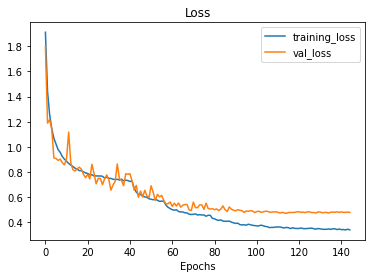

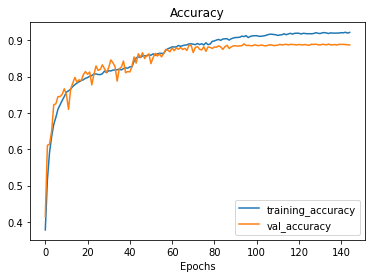

In [142]:
plot_loss_curves(history_14)

In [143]:
# model_4_opt_lr 200epochs
# EVALUATE THE MODEL
score = model_4_opt_lr.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.49929648637771606
Test Accuracy: 0.8827000260353088


หลังจาก optimizer Adam Algorithm ด้วย hyperparameter สามารถเพิ่ม accuracy มาเพียงนิดหน่อย และ ลด Loss ได้นิดหน่อย แต่สิ่งที่สังเกตุได้ คือหลังจากใช้ Early Stopping แล้ว Epochs ของรอบการ Training น่าจะอยู่ที่ 150 epochs กำลังดี

In [144]:
# SAVE MODEL
filepath = 'improve/model_4_opt_lr-model.h5'
model_4_opt_lr.save(filepath)

## 6. PREDICTION

Predict ภาพจาก Testing dataset แล้วแปลงค่าความเชื่อมั่นให้เป็นหมายเลขของ Class

In [145]:
# LOAD PREDICT MODEL
filepath = 'improve/model_4_opt_lr-model.h5'
predict_model = load_model(filepath)
predict_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)       

In [146]:
# PREDICTION IMAGE FROM TESTING DATASET
predicted_classes = predict_model.predict(test_data)
predicted_classes

array([[2.0689752e-06, 3.1970085e-05, 1.1785936e-04, ..., 1.7680040e-07,
        5.6532764e-07, 6.2650436e-08],
       [1.4290342e-06, 2.6125169e-01, 2.7394642e-10, ..., 1.4087989e-12,
        7.3874509e-01, 1.7616289e-06],
       [2.2769314e-05, 9.0223312e-01, 1.6416487e-07, ..., 5.9162574e-08,
        9.7714670e-02, 2.7398220e-05],
       ...,
       [1.1696081e-08, 3.3626300e-09, 5.0213737e-05, ..., 1.7484828e-06,
        1.5131032e-08, 6.1418476e-08],
       [6.1265887e-06, 9.9961096e-01, 4.4043736e-06, ..., 3.5946195e-07,
        9.9621514e-07, 5.2060777e-06],
       [1.2182726e-07, 3.2006176e-07, 1.1932345e-07, ..., 9.9986947e-01,
        2.0078383e-08, 1.4883750e-08]], dtype=float32)

In [147]:
predicted_classes = np.argmax(predicted_classes, axis=1)
predicted_classes

array([3, 8, 1, ..., 5, 1, 7], dtype=int64)

แปลงผลเฉลยที่มีการเข้ารหัสแบบ One-hot encoding เป็นหมายเลขของ Class เพื่อใช้ในการสร้าง Confusion Matrix

In [148]:
y_true = np.argmax(y_test, axis=1)
y_true

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [149]:
cm = confusion_matrix(y_true, predicted_classes)
cm

array([[890,  16,  28,   5,   6,   0,   7,   2,  25,  21],
       [  2, 972,   0,   0,   1,   1,   1,   0,   2,  21],
       [ 28,   1, 836,  18,  28,  15,  56,   7,   6,   5],
       [ 11,   5,  26, 722,  43,  82,  84,  11,   5,  11],
       [  7,   1,  28,   8, 878,   9,  56,  12,   1,   0],
       [  7,   4,  24,  74,  32, 790,  45,  19,   2,   3],
       [  3,   1,   6,   9,   4,   0, 973,   2,   1,   1],
       [  8,   1,  11,   6,  26,  19,  18, 906,   1,   4],
       [ 36,  17,   1,   1,   0,   0,   5,   1, 920,  19],
       [  3,  44,   2,   0,   1,   1,   3,   1,   5, 940]], dtype=int64)

จะเห็นว่าในแต่ละ คลาสจะมีอยู่ 1,000 ตัวอย่าง เราลองนับจำนวนข้อมูลดูว่าแต่ละ class มี 1,000 ตัวอย่างจริงมั้ย

In [150]:
c = Counter(y_true)
c

Counter({3: 1000,
         8: 1000,
         0: 1000,
         6: 1000,
         1: 1000,
         9: 1000,
         5: 1000,
         7: 1000,
         4: 1000,
         2: 1000})

ทำการ plot cunfusion matrix ด้วย `Plotly`

In [151]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def cm_plot(cm, labels):
    x = labels
    y = labels
    
    z_text = [[str(y) for y in x] for x in cm]
    fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='blues')
    
    fig.update_layout(title_text='Confusion Matrix')
    fig.add_annotation(dict(font=dict(color='black', size=13),
                           x=0.5,
                           y=-0.15,
                           showarrow=False,
                           text='Predicted Value',
                           xref='paper',
                           yref='paper'))
    
    fig.add_annotation(dict(font=dict(color='black', size=13),
                           x=-0.20,
                           y=0.5,
                           showarrow=False,
                           text='Real Value',
                           textangle=-90,
                           xref='paper',
                           yref='paper'))
    fig.update_layout(margin=dict(t=50, l=200))
    fig['layout']['yaxis']['autorange'] = 'reversed'
    fig['data'][0]['showscale'] = True
    fig.show()
    

In [74]:
cm_plot(cm, labels)

![](image/cmplot.png)

จากนั้นมาดูค่า `Precision`, `Recall`, `F1-score` ด้วย `Classification_report`

In [152]:
print(classification_report(y_true, predicted_classes, target_names=labels, digits=4))

              precision    recall  f1-score   support

    airplane     0.8945    0.8900    0.8922      1000
  automobile     0.9153    0.9720    0.9428      1000
        bird     0.8690    0.8360    0.8522      1000
         cat     0.8565    0.7220    0.7835      1000
        deer     0.8616    0.8780    0.8697      1000
         dog     0.8615    0.7900    0.8242      1000
        frog     0.7796    0.9730    0.8657      1000
       horse     0.9428    0.9060    0.9240      1000
        ship     0.9504    0.9200    0.9350      1000
       truck     0.9171    0.9400    0.9284      1000

    accuracy                         0.8827     10000
   macro avg     0.8848    0.8827    0.8818     10000
weighted avg     0.8848    0.8827    0.8818     10000



- `Precision`
นิยามของ Precision คือความน่าจะเป็นที่โมเดลทำนาย class ที่ถูกต้องจากการทำนาย Class ทั้งหมด 1000 ครั้ง (ผลรวมแถวบนของ confusion matrix)

- `Recall`
นิยามของ Recall คือความน่าจะเป็นที่โมเดลสามารถตรวจจับ Class จากจำนวน class ทั้งหมดในข้อมูลของเรา  (ผลรวมคอลั่มแรกของ confusion matrix)

- `F1-Score`
F1-Score คือค่าเฉลี่ยแบบ harmonic mean ระหว่าง precision และ recall ที่วัดความสามารถของโมเดล (ไม่ต้องเลือกระหว่าง precision, recall เพราะเฉลี่ยให้แล้ว)

จากนั้นเราจะ Plot `AUC curve` และคำนวณ `ROC` ของภาพแต่ละ Class ดังนั้นต้องใช้ค่าความเชื่อมั่นในแต่ละ class ในการคำนวณ `True positive rate` และ `False Positive Rate`

In [153]:
predicted_score = predict_model.predict(test_data)
predicted_score.shape, y_test.shape

((10000, 10), (10000, 10))

In [154]:
# PLOT ROC CURVE & AUC FOR 10 classes
hovertemplate = 'False Prositive Rate = %{x:.4f}<br>True Positive Rate=%{y:.4f}<br>Threshold=%{text:.4f}'

fig = go.Figure()
fig.add_shape(type='line', line=dict(dash='dash'),
             x0=0, x1=1, y0=0, y1=1)

for i in range(predicted_score.shape[1]):
    y_real = y_test[:, i]
    y_score = predicted_score[:, i]
    
    fpr, tpr, threshold = roc_curve(y_real, y_score)
    auc_score = auc(fpr, tpr)
    
    name = f"{labels[i]}, AUC={auc_score:.4f}"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines',
                            text=threshold, hovertemplate=hovertemplate))
    
fig.update_layout(title='ROC Curve and AUC',
                 xaxis_title='False Positive Rate',
                 yaxis_title='True Positive Rate')

fig.show()

![](image/rocauc.png)

AUC ย่อมาจาก “Area Under (ROC) Curve” เป็นอีกหนึ่ง metric ยอดนิยมที่ใช้กันแทบทุกงานเลย AUC มีค่าอยู่ระหว่าง 0-1 ยิ่งเข้าใกล้ 1 แปลว่าโมเดลในภาพรวมสามารถทำนายได้ดีมาก

* AUC = 0.50 ไม่ต่างอะไรกับการเดาสุ่มเลย
* AUC > 0.70 คือเกณฑ์มาตรฐานสำหรับโมเดลส่วนใหญ่
* AUC > 0.80 โมเดลทำงานได้ดี
* AUC > 0.90 โมเดลทำงานได้ดีมา

จะเห็นว่า `Class 3 (cat)` มีค่า ROC น้อยกว่า Class อื่นๆ อย่างเห็นได้ชัด ซึ่งแสดงว่า Model ของเรามีความสามารถในการแยกภาพ Class 3 ออกจาก Class อื่นๆ ได้ไม่ดีนัก ดังนั้นเราจะกรองภาพเฉพาะ Class นี้ที่ทำนายผิด มา Plot เพื่อทำความเข้าใจ

In [155]:
y_true, predicted_classes

(array([3, 8, 8, ..., 5, 1, 7], dtype=int64),
 array([3, 8, 1, ..., 5, 1, 7], dtype=int64))

In [156]:
false_predict = y_true != predicted_classes

class3 = y_true==3

false_predict_class3 = class3 & false_predict

Counter(false_predict_class3)

Counter({False: 9722, True: 278})

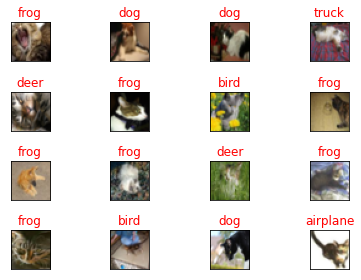

In [157]:
class3_img = test_data[false_predict_class3]
class3_y = predicted_classes[false_predict_class3]
false_predict_labels = [labels[class_num] for class_num in class3_y]

for i in range(16):
    ax = plt.subplot(4, 4, 1+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('%s'%(false_predict_labels[i]), color='red')
    plt.imshow(class3_img[i], cmap=plt.get_cmap('Blues'))
plt.tight_layout()

จากภาพด้านบน Class 3 (cat) ของ Test dataset พบว่า model ทำนายผิดเป็น class ต่างๆได้แก่ frog, dog, deer และ bird
ซึ่งดูเหมือนว่าบางภาพใน Cifar-10 dataset นั้นจะถูก Label มายังไม่ถูกต้อง ดังเช่นภาพแรกของแถวที่ 2 ที่ควร Label ว่า Cat มากกว่า Frog

ในกรณีทำงานจริงๆ หากพบว่ามีการ Label ไม่ถูกต้องเป็นจำนวนมาก เราอาจต้องกลับไปแก้ไขการ Label Dataset (Train/Validate/Test) ใหม่ก่อน แล้วค่อยกลับมา Train Model ใหม่อีกครั้ง

# 7. SUMMARY

สรุป ในการทดลลองทำ `CIFAR-10 dataset` โดยการทำการสร้าง `ConvNet Model` และการแก้ปัญหา` Overfitting` โดยการทำให้ภาพมีความหลากหลายด้วยเทคนิค Image Augmentation จากนั้นทำ Regularizations เพื่อแก้ปัญหาการเกิด Overfitting ได้แก่ Batch Normalization และ Dropout โดยได้ทดลองทำ 3 แบบ คือ :
1. ใช้เฉพาะการทำ `Image Augmentation `
2. ใช้การทำ `Image Augmentation` และ `Batch Normalization`
3. ใช้การทำ `Image Augmentation` ร่วมกับ `Batch Normalization` และ `Dropout`

โดยเราสามารถดูได้จากกราฟ Loss ได้ว่า Model เกิดปัญหา Overfitting หรือไม่ ซึ่งโมเดลที่มีประสิทธิภาพดี นอกจากจะทำนาย Test Dataset ได้ค่าที่สูงแล้ว ต้องเป็นโมเดลที่ไม่เกิด `Overfitting` อีกด้วย